In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 8.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=580f761c0ce6556e55706b1e9123e871a72f13910efcff9b8adb823acf342c12
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Spark Session


In [3]:
import pandas as pd
import io
import matplotlib.pyplot as plt

from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import sum,avg,max,min,mean,count,sqrt
from pyspark.sql.functions import col,when
from pyspark.sql import functions as F 
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns

In [4]:
#Initialize a spark session.
def spark_intialization():
    spark = SparkSession \
        .builder \
        .appName("Pyspark Project") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [5]:
# Initialise spark object
spark = spark_intialization()
spark

# DATA PREPROCESSING

In [6]:
from pyspark.sql import functions as pyspark_functions
from pyspark.sql.types import *
schema = StructType([ \
                     StructField("USER_ID", IntegerType(), True), \
                     StructField("Steam_Game", StringType(), True),\
                     StructField("Behaviour_Name", StringType(), True),\
                    StructField("Hours_played", FloatType(), True)])
dataframes = spark.read.schema(schema).csv("/content/drive/MyDrive/GOOGLE_COLAB/BigData/steam-200k.csv", header=False)
dataframes.show(10)

+---------+--------------------+--------------+------------+
|  USER_ID|          Steam_Game|Behaviour_Name|Hours_played|
+---------+--------------------+--------------+------------+
|151603712|The Elder Scrolls...|      purchase|         1.0|
|151603712|The Elder Scrolls...|          play|       273.0|
|151603712|           Fallout 4|      purchase|         1.0|
|151603712|           Fallout 4|          play|        87.0|
|151603712|               Spore|      purchase|         1.0|
|151603712|               Spore|          play|        14.9|
|151603712|   Fallout New Vegas|      purchase|         1.0|
|151603712|   Fallout New Vegas|          play|        12.1|
|151603712|       Left 4 Dead 2|      purchase|         1.0|
|151603712|       Left 4 Dead 2|          play|         8.9|
+---------+--------------------+--------------+------------+
only showing top 10 rows



In [7]:
dataframes = dataframes.withColumnRenamed("_c0","USER_ID").withColumnRenamed("_c1","Steam_Game").withColumnRenamed("_c2","Behaviour_Name").withColumnRenamed("_c3","Hours_played")
dataframes = dataframes.drop("_c4")
dataframes.show(10)

+---------+--------------------+--------------+------------+
|  USER_ID|          Steam_Game|Behaviour_Name|Hours_played|
+---------+--------------------+--------------+------------+
|151603712|The Elder Scrolls...|      purchase|         1.0|
|151603712|The Elder Scrolls...|          play|       273.0|
|151603712|           Fallout 4|      purchase|         1.0|
|151603712|           Fallout 4|          play|        87.0|
|151603712|               Spore|      purchase|         1.0|
|151603712|               Spore|          play|        14.9|
|151603712|   Fallout New Vegas|      purchase|         1.0|
|151603712|   Fallout New Vegas|          play|        12.1|
|151603712|       Left 4 Dead 2|      purchase|         1.0|
|151603712|       Left 4 Dead 2|          play|         8.9|
+---------+--------------------+--------------+------------+
only showing top 10 rows



# FEATURE ADDITION

In [8]:
new_feature =dataframes.filter("Hours_played > 1") and dataframes.filter("Behaviour_Name =='play'")
new_feature.select("Behaviour_Name").distinct().collect()
new_feature.select('Steam_Game').distinct().count()
average = new_feature.groupBy("Steam_Game") \
             .agg(mean("Hours_played").alias("mean_Hourplayed")) \
             .select("Steam_Game", "mean_Hourplayed")
newfeature = new_feature.join(average, on="Steam_Game", how="inner")
newfeature.show()

+--------------------+---------+--------------+------------+------------------+
|          Steam_Game|  USER_ID|Behaviour_Name|Hours_played|   mean_Hourplayed|
+--------------------+---------+--------------+------------+------------------+
|The Elder Scrolls...|151603712|          play|       273.0|104.71093058112893|
|           Fallout 4|151603712|          play|        87.0| 64.44790419641726|
|               Spore|151603712|          play|        14.9|29.424137906524642|
|   Fallout New Vegas|151603712|          play|        12.1| 51.68257840416469|
|       Left 4 Dead 2|151603712|          play|         8.9| 41.94344569319457|
|            HuniePop|151603712|          play|         8.5|20.820000019669532|
|       Path of Exile|151603712|          play|         8.1|  53.3277487010934|
|         Poly Bridge|151603712|          play|         7.5| 5.383333285649617|
|         Left 4 Dead|151603712|          play|         3.3| 42.45049018993535|
|     Team Fortress 2|151603712|        

In [9]:
from pyspark.sql.functions import when
newfeature = newfeature.withColumn("rating", 
                   when(newfeature["Hours_played"] >= 0.8 * newfeature["mean_Hourplayed"], 5)
                   .when((newfeature["Hours_played"] >= 0.6 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.8 * newfeature["mean_Hourplayed"]), 4)
                   .when((newfeature["Hours_played"] >= 0.4 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.6 * newfeature["mean_Hourplayed"]), 3)
                   .when((newfeature["Hours_played"] >= 0.2 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.4 * newfeature["mean_Hourplayed"]), 2)
                   .otherwise(1))
newfeature.show()

+--------------------+---------+--------------+------------+------------------+------+
|          Steam_Game|  USER_ID|Behaviour_Name|Hours_played|   mean_Hourplayed|rating|
+--------------------+---------+--------------+------------+------------------+------+
|The Elder Scrolls...|151603712|          play|       273.0|104.71093058112893|     5|
|           Fallout 4|151603712|          play|        87.0| 64.44790419641726|     5|
|               Spore|151603712|          play|        14.9|29.424137906524642|     3|
|   Fallout New Vegas|151603712|          play|        12.1| 51.68257840416469|     2|
|       Left 4 Dead 2|151603712|          play|         8.9| 41.94344569319457|     2|
|            HuniePop|151603712|          play|         8.5|20.820000019669532|     3|
|       Path of Exile|151603712|          play|         8.1|  53.3277487010934|     1|
|         Poly Bridge|151603712|          play|         7.5| 5.383333285649617|     5|
|         Left 4 Dead|151603712|          p

In [10]:
newfeature.groupBy("rating").count().show()

+------+-----+
|rating|count|
+------+-----+
|     1|28421|
|     3| 5746|
|     5|22935|
|     4| 4281|
|     2| 9106|
+------+-----+



In [11]:
newfeature.count()

70489

## EXPLORATORY DATA ANALYSIS

In [12]:
total_records = dataframes.count()
print("Total records in dataframe", total_records)

Total records in dataframe 200000


In [13]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
dataframes.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataframes.columns]
   ).show(truncate=False)

+-------+----------+--------------+------------+
|USER_ID|Steam_Game|Behaviour_Name|Hours_played|
+-------+----------+--------------+------------+
|0      |0         |0             |0           |
+-------+----------+--------------+------------+



In [14]:
#checking for duplicate values
#Hours if behavior is play, 1.0 if behavior is purchase
dataframes.groupBy("USER_ID","Steam_Game","Behaviour_Name").count().filter("count > 1").show(50)

+---------+--------------------+--------------+-----+
|  USER_ID|          Steam_Game|Behaviour_Name|count|
+---------+--------------------+--------------+-----+
| 11373749|Sid Meier's Civil...|      purchase|    2|
|  2259650|Grand Theft Auto ...|      purchase|    2|
|164561444|Sid Meier's Civil...|      purchase|    2|
| 17530772|Grand Theft Auto ...|      purchase|    2|
|  2259650|Sid Meier's Civil...|      purchase|    2|
|101695880|Grand Theft Auto ...|      purchase|    2|
|166048025|Sid Meier's Civil...|      purchase|    2|
| 81585721|Grand Theft Auto III|      purchase|    2|
| 31733621|Sid Meier's Civil...|      purchase|    2|
|116876958|Sid Meier's Civil...|      purchase|    2|
| 84513749|Sid Meier's Civil...|      purchase|    2|
| 54761333|Sid Meier's Civil...|      purchase|    2|
| 64787956|Grand Theft Auto ...|      purchase|    2|
|100351493|Sid Meier's Civil...|      purchase|    2|
| 33865373|Grand Theft Auto III|      purchase|    2|
| 71390526|Sid Meier's Civil

In [15]:
#no of duplicate rows 
dataframes.groupBy("USER_ID","Steam_Game","Behaviour_Name").count().filter("count > 1").count()

719

In [16]:
#storing distinct datapoints of our dataset in distinctDF
df = dataframes.distinct()
print("Distinct count: "+str(df.count()))

Distinct count: 199293


In [17]:
#counting distinct users and games on the platform.
total_users = df.select(['USER_ID']).distinct().count()
total_games = df.select(['Steam_Game']).distinct().count()
total_hours = df.select(['Hours_played']).distinct().count()
print("Total No of Users  :", total_users)
print("Total No of Games :", total_games)
print("Total No of hours played by user :", total_hours)

Total No of Users  : 12393
Total No of Games : 5155
Total No of hours played by user : 1593


In [18]:
def sparsity(df):
    # Count the number of ratings in the rating dataframe
    hours_played = df.select("Hours_played").count()
    
    # Total Number of distinct users and animes
    total_element = total_users*total_games
    #print(total_element)
    # Calculate  % Sparsity of Matrix Fomrula (1-(rating_count)/(total_element))*100
    sparsity = (1-(hours_played)/total_element)*100
    print(" The dataframe is ", "%.2f" % sparsity +"% sparse")

In [19]:
sparsity(df)

 The dataframe is  99.69% sparse


In [20]:
#Most number of hours played Games
topGames=df.groupBy("Steam_Game") \
    .agg(count("Hours_played").alias("Hours")) \
    .sort(desc("Hours"))
topGames.show(10)

+--------------------+-----+
|          Steam_Game|Hours|
+--------------------+-----+
|              Dota 2| 9682|
|     Team Fortress 2| 4646|
|Counter-Strike Gl...| 2789|
|            Unturned| 2632|
|       Left 4 Dead 2| 1752|
|Counter-Strike So...| 1693|
|      Counter-Strike| 1424|
|         Garry's Mod| 1397|
|The Elder Scrolls...| 1394|
|            Warframe| 1271|
+--------------------+-----+
only showing top 10 rows



In [21]:
#Top paid Games 
topPurchaseGames = df.filter("Behaviour_Name == 'purchase'").groupBy("Steam_Game","Behaviour_Name").count().sort(desc("count"))
topPurchaseGames.show()

+--------------------+--------------+-----+
|          Steam_Game|Behaviour_Name|count|
+--------------------+--------------+-----+
|              Dota 2|      purchase| 4841|
|     Team Fortress 2|      purchase| 2323|
|            Unturned|      purchase| 1563|
|Counter-Strike Gl...|      purchase| 1412|
|Half-Life 2 Lost ...|      purchase|  981|
|Counter-Strike So...|      purchase|  978|
|       Left 4 Dead 2|      purchase|  951|
|      Counter-Strike|      purchase|  856|
|            Warframe|      purchase|  847|
|Half-Life 2 Death...|      purchase|  823|
|         Garry's Mod|      purchase|  731|
|The Elder Scrolls...|      purchase|  717|
|           Robocraft|      purchase|  689|
|Counter-Strike Co...|      purchase|  679|
|Counter-Strike Co...|      purchase|  679|
|   Heroes & Generals|      purchase|  658|
|         Half-Life 2|      purchase|  639|
|Sid Meier's Civil...|      purchase|  596|
|         War Thunder|      purchase|  590|
|              Portal|      purc

In [22]:
#Top played Games 
topPlayedGames = df.filter("Behaviour_Name == 'play'").groupBy("Steam_Game","Behaviour_Name").count().sort(desc("count"))
topPlayedGames.show()

+--------------------+--------------+-----+
|          Steam_Game|Behaviour_Name|count|
+--------------------+--------------+-----+
|              Dota 2|          play| 4841|
|     Team Fortress 2|          play| 2323|
|Counter-Strike Gl...|          play| 1377|
|            Unturned|          play| 1069|
|       Left 4 Dead 2|          play|  801|
|Counter-Strike So...|          play|  715|
|The Elder Scrolls...|          play|  677|
|         Garry's Mod|          play|  666|
|      Counter-Strike|          play|  568|
|Sid Meier's Civil...|          play|  554|
|            Terraria|          play|  460|
|            Portal 2|          play|  453|
|            Warframe|          play|  424|
|              Portal|          play|  417|
|           Robocraft|          play|  407|
|            PAYDAY 2|          play|  390|
|       Borderlands 2|          play|  386|
|         Half-Life 2|          play|  356|
|   Heroes & Generals|          play|  335|
|         War Thunder|          

In [23]:
df.show

<bound method DataFrame.show of DataFrame[USER_ID: int, Steam_Game: string, Behaviour_Name: string, Hours_played: float]>

In [24]:
dataframes.select("Hours_played").describe().show()

+-------+------------------+
|summary|      Hours_played|
+-------+------------------+
|  count|            200000|
|   mean|17.874384000420385|
| stddev| 138.0569516508248|
|    min|               0.1|
|    max|           11754.0|
+-------+------------------+



In [25]:
# no_of_rated_anime_per_user = train.groupBy('user_id').agg(F.count('*').alias('Frequency')).orderBy('Frequency',ascending=0)
# no_of_rated_anime_per_user.show()

## Outlier Analysis

In [26]:
#Calculate Upper, Lower and InterQuartlie Range
def calculate_bounds(df):
  c = "Hours_played"
  bounds = {
        c: dict(
            zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
        )
      
    }
  iqr = bounds[c]['q3'] - bounds[c]['q1']
  bounds[c]['min'] = bounds[c]['q1'] - (iqr * 1.5)
  bounds[c]['max'] = bounds[c]['q3'] + (iqr * 1.5)
  return bounds

In [27]:
#Indicate the presence of Outlier in the specic Column
def flag_outliers(df, id_col):
  bounds = calculate_bounds(df)
  outliers = {}
  c = "Hours_played"
  return df.select(c, id_col,
        *[
            F.when(
                ~F.col(c).between(bounds[c]['min'], bounds[c]['max']),
                "yes"
            ).otherwise("no").alias(c+'_outlier')
        ]
  )
    

In [28]:
#Columns Containing Outliers
outlier_data = flag_outliers(df,'USER_ID')
outlier_data.show()

+------------+---------+--------------------+
|Hours_played|  USER_ID|Hours_played_outlier|
+------------+---------+--------------------+
|        11.2| 53875128|                 yes|
|         1.0| 53875128|                  no|
|         1.9| 53875128|                  no|
|         1.4| 53875128|                  no|
|         0.4| 53875128|                 yes|
|         1.0|126340495|                  no|
|         9.2| 97298878|                 yes|
|         0.9| 97298878|                  no|
|       211.0| 48845802|                 yes|
|         1.0| 62923086|                  no|
|        14.6| 65117175|                 yes|
|         1.0| 65117175|                  no|
|         2.0|236557903|                 yes|
|         1.0| 11373749|                  no|
|         1.0| 11373749|                  no|
|         1.0| 11373749|                  no|
|         1.0|264253640|                  no|
|         1.0|  5270060|                  no|
|         1.0|151229648|          

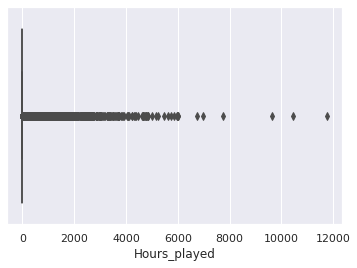

In [29]:
panda_df= df.toPandas()
sns.set()
ax = sns.boxplot(x=panda_df['Hours_played'])